In [1]:
import pandas as pd
import numpy as np
import torch
import re
import json
import spacy
import contractions
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config

# 1: Load the Data

In [2]:
# Load the JSON file into a Python dictionary
with open('data/dev-v1.1.json') as f:
    data_d = json.load(f)
    
with open('data/train-v1.1.json') as f:
    data_t = json.load(f)

# Extract the 'paragraphs' from 'data' in JSON
paragraphs_d = data_d['data'][0]['paragraphs']
paragraphs_t = data_t['data'][0]['paragraphs']

# Normalize the JSON data to a DataFrame
df_dev = pd.json_normalize(paragraphs_d, record_path=['qas'], meta=['context'])
df_train = pd.json_normalize(paragraphs_t, record_path=['qas'], meta=['context'])

# 2: Exploratory Data Analysis 

## Check Basic Information:

In [3]:
print(df_dev.info())
print(df_dev.describe())
print(df_dev.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   answers   810 non-null    object
 1   question  810 non-null    object
 2   id        810 non-null    object
 3   context   810 non-null    object
dtypes: object(4)
memory usage: 25.4+ KB
None
                                                  answers  \
count                                                 810   
unique                                                571   
top     [{'answer_start': 177, 'text': 'Denver Broncos...   
freq                                                    7   

                                        question                        id  \
count                                        810                       810   
unique                                       800                       810   
top     How old was Newton during Super Bowl 50?  56be4db0acb8001400a502ec   
freq

In [4]:
print(df_train.info())
print(df_train.describe())
print(df_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   answers   269 non-null    object
 1   question  269 non-null    object
 2   id        269 non-null    object
 3   context   269 non-null    object
dtypes: object(4)
memory usage: 8.5+ KB
None
                                                  answers  \
count                                                 269   
unique                                                268   
top     [{'answer_start': 11, 'text': 'Father John Fra...   
freq                                                    2   

                                                 question  \
count                                                 269   
unique                                                269   
top     To whom did the Virgin Mary allegedly appear i...   
freq                                                    1   

           

The DataFrames df_dev and df_train have columns such as question, context, answers, and id. 
For a generative chatbot, the key components are:

1. context (the background information)
2. question (the prompts or user queries)
3. answers (responses that provide relevant data)

## Data Quality Checks:

In [5]:
# Check for missing values in columns like context, question, and answers

print(df_dev.isnull().sum())
print(df_train.isnull().sum())

answers     0
question    0
id          0
context     0
dtype: int64
answers     0
question    0
id          0
context     0
dtype: int64


# 3: Data Cleaning and Preprocessing

## Tokenization and Text Normalization

In [6]:
nlp = spacy.load('en_core_web_lg')

# Load the tokenizer for distilgpt2
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')

def calculate_token_length(text):
    return len(tokenizer.encode(text))

df_dev['token_length'] = df_dev.apply(lambda row: calculate_token_length(row['context'] + ' ' + row['question'] + ' ' + row.get('answer_text', '')), axis=1)
df_train['token_length'] = df_train.apply(lambda row: calculate_token_length(row['context'] + ' ' + row['question'] + ' ' + row.get('answer_text', '')), axis=1)



/Users/jabalishah/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


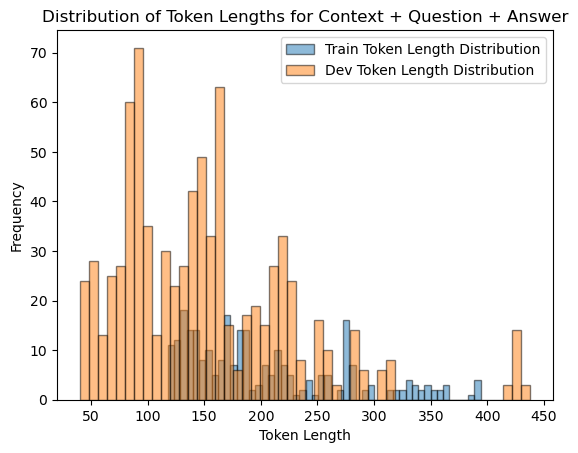

In [7]:
# Plotting the distribution of token lengths
plt.hist(df_train['token_length'], bins=50, alpha=0.5, label='Train Token Length Distribution', edgecolor='black')
plt.hist(df_dev['token_length'], bins=50, alpha=0.5, label='Dev Token Length Distribution', edgecolor='black')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths for Context + Question + Answer')
plt.legend()
plt.show()

## Handle Nested Answers

In [8]:
# The answers column contains a list of dictionaries, so extract the text for easier processing

df_dev['answer_text'] = df_dev['answers'].apply(lambda x: x[0]['text'] if len(x) > 0 else '')
df_train['answer_text'] = df_train['answers'].apply(lambda x: x[0]['text'] if len(x) > 0 else '')


## Remove Empty Rows

In [9]:
# If any rows have empty context, question, or answer_text after cleaning, remove them

df_dev = df_dev[df_dev['context'].str.strip() != '']
df_dev = df_dev[df_dev['question'].str.strip() != '']
df_dev = df_dev[df_dev['answer_text'].str.strip() != '']

df_train = df_train[df_train['context'].str.strip() != '']
df_train = df_train[df_train['question'].str.strip() != '']
df_train = df_train[df_train['answer_text'].str.strip() != '']


# 4: Prepare Data for Model Training

## Combine Context and Question

In [10]:
# To create a prompt-response pair, combine the context and question into a single prompt

df_dev['input_text'] = df_dev['context'] + " " + df_dev['question']
df_dev['target_text'] = df_dev['answer_text']

df_train['input_text'] = df_train['context'] + " " + df_train['question']
df_train['target_text'] = df_train['answer_text']
